In [ ]:
#preliminary imports
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt 
import numpy as np 
import time
from tensorflow.keras import layers
import cv2

#for gif generation
import imageio

In [ ]:
#create dataset from ./training_data/
#first define some parameters:
#first start at 50 per batch, then move up

BATCH_SIZE = 50
IMG_WIDTH = 128
IMG_HEIGHT = 128

train_dir = r'./test_data/'

In [ ]:
#create the training dataset
#note that we do not use validation here since validation comes from the classifier, so all images are used for training here

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = None
)

In [ ]:
#check to see if the shape of the training data is correct
for image_batch in train_ds:
  print(image_batch.shape)
  print(image_batch)
  break

In [ ]:
#normalize the rgb data to be [0 - 1]
train_ds = train_ds.map(lambda x: (x / 127.5) - 1)

for image_batch in train_ds:
  print(image_batch.shape)
  print(image_batch)
  break

In [ ]:
#create the generator model
def make_generator():
    model = tf.keras.Sequential()
    #first dense layer
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)
    #2nd layer -- downsample filters from 256 -> 128
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #3rd layer -- increase resolution to 16x16 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #4th layer -- increase resolution to 32x32 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #5th layer -- increase resolution to 64x64 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #6th layer -- increase resolution to 128x128 and 128 filters
    model.add(layers.Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #Final layer -- conv2d to 3 filters(RGB)
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    assert model.output_shape == (None, 128, 128, 3)
    return model

In [ ]:
#generate an image
generator = make_generator()

noise = tf.random.normal([1, 100])
image = generator(noise, training=False)
image = (image + 1) / 2.0

plt.imshow(image[0,:,:,:])

In [ ]:
#CNN based discriminator
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [ ]:
#classify our generated image
discriminator = make_discriminator()
decision = discriminator(image)
print(decision)

In [ ]:
#discriminator loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#checkpoint setup
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#training step
@tf.function
def train_step(images):
    #print(images.shape)

    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        generator_loss = gen_loss(fake_output)
        discrimiator_loss = disc_loss(real_output, fake_output)

        gen_gradients = gen_tape.gradient(generator_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(discrimiator_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Epoch " + str(epoch) + " started")
    start = time.time()

    batch = 1
    for image_batch in dataset:
        
        #print("Batch " + str(batch) + " started")
        #print(image_batch.shape)
        train_step(image_batch)

        
        #print("Batch " + str(batch) + " finished")
        batch += 1

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = (predictions + 1) / 2.0

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('./generated_images/image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

Epoch 0 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


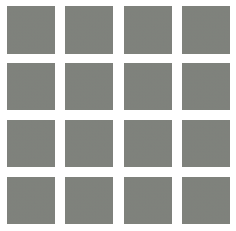

Time for epoch 1 is 20.309173107147217 sec
Epoch 1 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


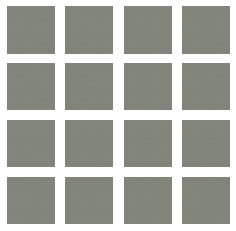

Time for epoch 2 is 14.151991605758667 sec
Epoch 2 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


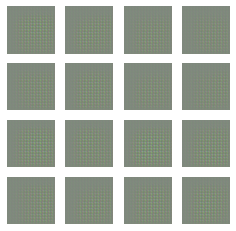

Time for epoch 3 is 14.21322774887085 sec
Epoch 3 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


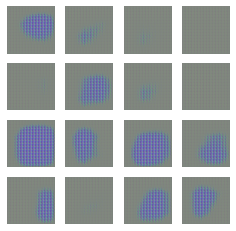

Time for epoch 4 is 14.414226293563843 sec
Epoch 4 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


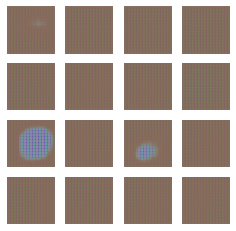

Time for epoch 5 is 14.34488034248352 sec
Epoch 5 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


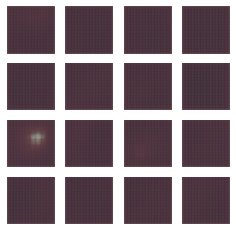

Time for epoch 6 is 14.53687858581543 sec
Epoch 6 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


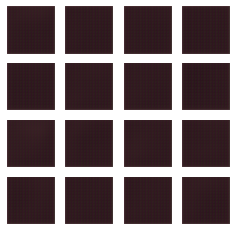

Time for epoch 7 is 14.421998023986816 sec
Epoch 7 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


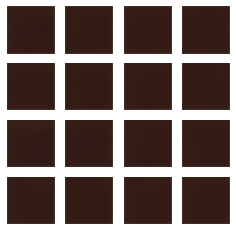

Time for epoch 8 is 14.463139533996582 sec
Epoch 8 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


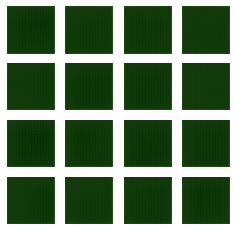

Time for epoch 9 is 14.43017578125 sec
Epoch 9 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


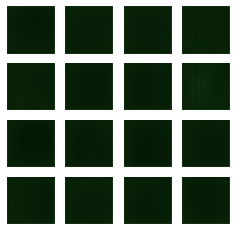

Time for epoch 10 is 14.496999740600586 sec
Epoch 10 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


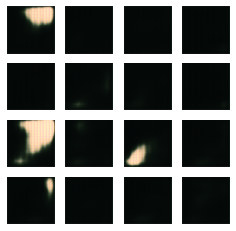

Time for epoch 11 is 14.623028755187988 sec
Epoch 11 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


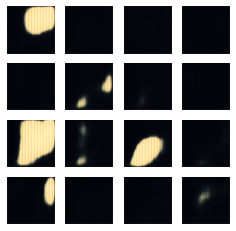

Time for epoch 12 is 14.212998151779175 sec
Epoch 12 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


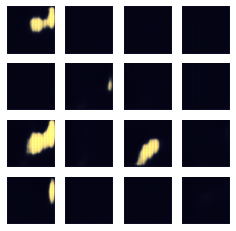

Time for epoch 13 is 14.460999727249146 sec
Epoch 13 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


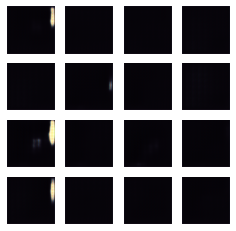

Time for epoch 14 is 14.578238248825073 sec
Epoch 14 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


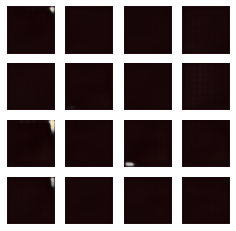

Time for epoch 15 is 14.995891094207764 sec
Epoch 15 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


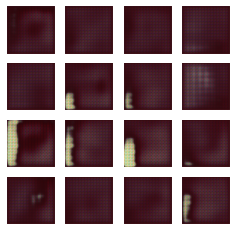

Time for epoch 16 is 14.308017015457153 sec
Epoch 16 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


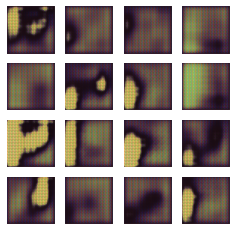

Time for epoch 17 is 14.511997938156128 sec
Epoch 17 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


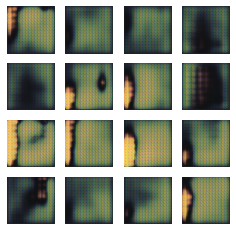

Time for epoch 18 is 14.880001068115234 sec
Epoch 18 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


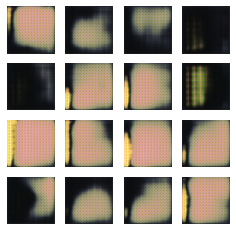

Time for epoch 19 is 15.161999940872192 sec
Epoch 19 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


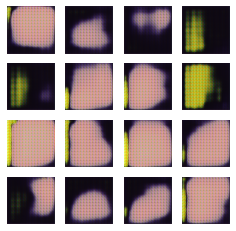

Time for epoch 20 is 15.081001281738281 sec
Epoch 20 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


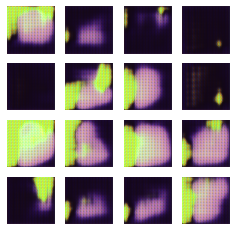

Time for epoch 21 is 15.06799840927124 sec
Epoch 21 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


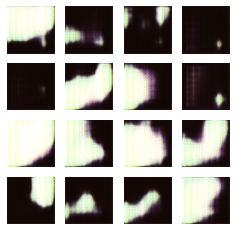

Time for epoch 22 is 15.229002475738525 sec
Epoch 22 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


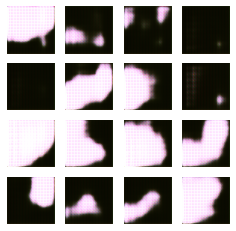

Time for epoch 23 is 15.238996982574463 sec
Epoch 23 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


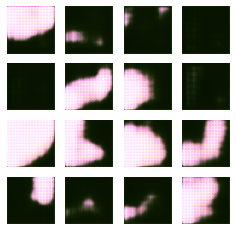

Time for epoch 24 is 15.277997732162476 sec
Epoch 24 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


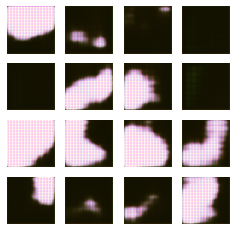

Time for epoch 25 is 15.217014789581299 sec
Epoch 25 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


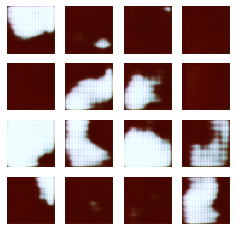

Time for epoch 26 is 15.379985570907593 sec
Epoch 26 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


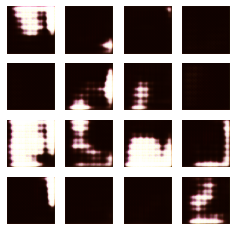

Time for epoch 27 is 15.338001251220703 sec
Epoch 27 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


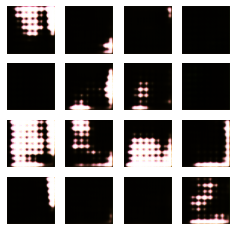

Time for epoch 28 is 15.445002317428589 sec
Epoch 28 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


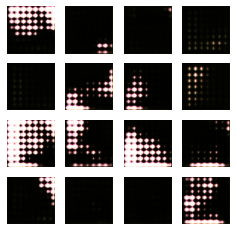

Time for epoch 29 is 15.353005409240723 sec
Epoch 29 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


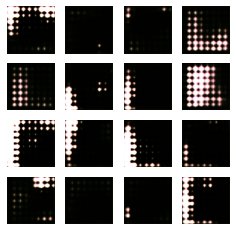

Time for epoch 30 is 15.837395429611206 sec
Epoch 30 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


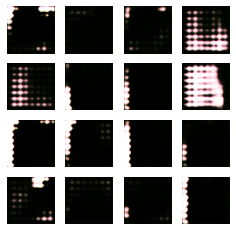

Time for epoch 31 is 15.379333734512329 sec
Epoch 31 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


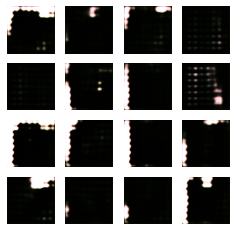

Time for epoch 32 is 15.407018899917603 sec
Epoch 32 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


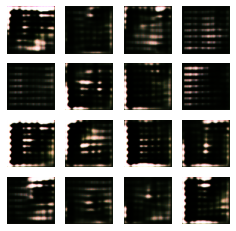

Time for epoch 33 is 15.550983428955078 sec
Epoch 33 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


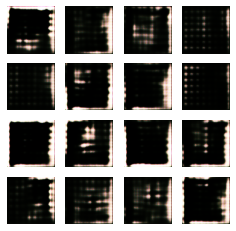

Time for epoch 34 is 14.984999418258667 sec
Epoch 34 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


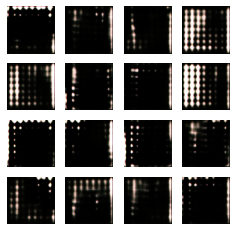

Time for epoch 35 is 15.607996702194214 sec
Epoch 35 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


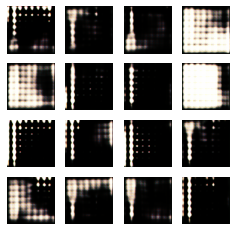

Time for epoch 36 is 15.728018760681152 sec
Epoch 36 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


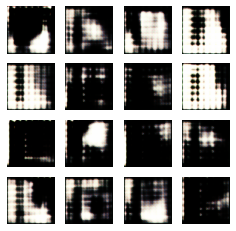

Time for epoch 37 is 15.847983837127686 sec
Epoch 37 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


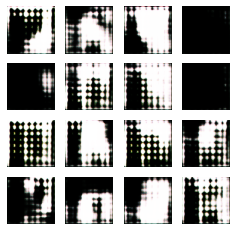

Time for epoch 38 is 15.683019876480103 sec
Epoch 38 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


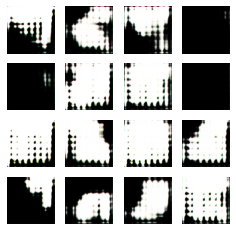

Time for epoch 39 is 15.815516710281372 sec
Epoch 39 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


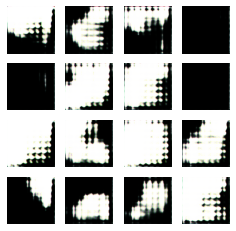

Time for epoch 40 is 15.29584288597107 sec
Epoch 40 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


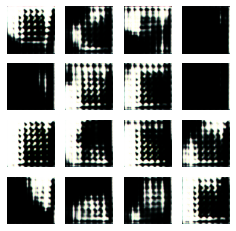

Time for epoch 41 is 14.624998331069946 sec
Epoch 41 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


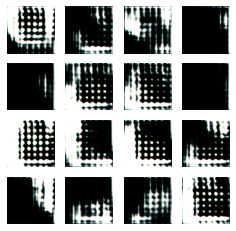

Time for epoch 42 is 15.559001684188843 sec
Epoch 42 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


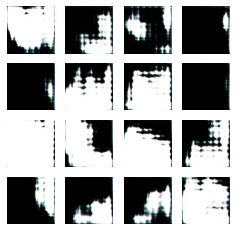

Time for epoch 43 is 13.729994058609009 sec
Epoch 43 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


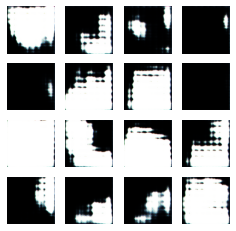

Time for epoch 44 is 13.759993314743042 sec
Epoch 44 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


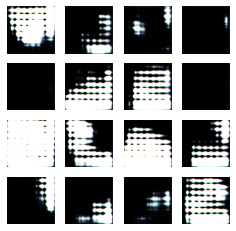

Time for epoch 45 is 14.108004808425903 sec
Epoch 45 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


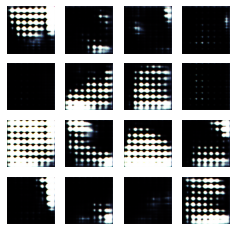

Time for epoch 46 is 13.973994493484497 sec
Epoch 46 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


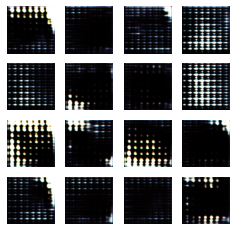

Time for epoch 47 is 14.760013580322266 sec
Epoch 47 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


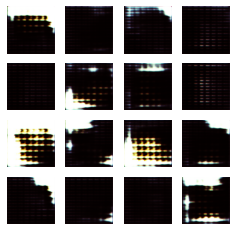

Time for epoch 48 is 15.903988122940063 sec
Epoch 48 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started
Batch 18 finished
Batch 19 started
Batch 19 finished
Batch 20 started
Batch 20 finished
Batch 21 started
Batch 21 finished
Batch 22 started
Batch 22 finished
Batch 23 started
Batch 23 finished
Batch 24 started
Batch 24 finished
Batch 25 started
Batch 25 finished


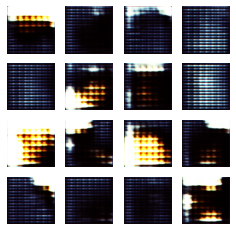

Time for epoch 49 is 16.204001426696777 sec
Epoch 49 started
Batch 1 started
Batch 1 finished
Batch 2 started
Batch 2 finished
Batch 3 started
Batch 3 finished
Batch 4 started
Batch 4 finished
Batch 5 started
Batch 5 finished
Batch 6 started
Batch 6 finished
Batch 7 started
Batch 7 finished
Batch 8 started
Batch 8 finished
Batch 9 started
Batch 9 finished
Batch 10 started
Batch 10 finished
Batch 11 started
Batch 11 finished
Batch 12 started
Batch 12 finished
Batch 13 started
Batch 13 finished
Batch 14 started
Batch 14 finished
Batch 15 started
Batch 15 finished
Batch 16 started
Batch 16 finished
Batch 17 started
Batch 17 finished
Batch 18 started


In [16]:
train(train_ds, EPOCHS)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)